# Model Trajectories vs Experimental Data

Plot 95% confidence intervals of model trajectories from fitted parameter sets alongside experimental data with standard error bars.

Layout: 2x3 grid
- Row 1: pSTAT3 trajectories
- Row 2: pSTAT1 trajectories
- Column 1: IL-6 only (1 ng/ml and 10 ng/ml)
- Column 2: IL-10 only (1 ng/ml and 10 ng/ml)
- Column 3: IL-6 + IL-10 (1+1 ng/ml and 10+10 ng/ml)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Model Trajectories

In [2]:
# Load trajectory data
pSTAT1_trajs = pd.read_csv('../Data/pSTAT1_trajs.csv', header=None)
pSTAT3_trajs = pd.read_csv('../Data/pSTAT3_trajs.csv', header=None)

# Load parameter sets to map conditions
param_sets_df = pd.read_csv('../Data/param_sets.csv')

print(f"pSTAT1 trajectories: {pSTAT1_trajs.shape} (rows=parameter sets x conditions, cols=timepoints)")
print(f"pSTAT3 trajectories: {pSTAT3_trajs.shape}")
print(f"Parameter sets: {param_sets_df.shape}")

# Data structure: 6 conditions per parameter set, organized in blocks
# Each block of 6 rows corresponds to one parameter set:
# - Row i+0: IL6=1, IL10=0
# - Row i+1: IL10=1, IL6=0  
# - Row i+2: IL6=10, IL10=0
# - Row i+3: IL6=10, IL10=10
# - Row i+4: IL10=10, IL6=0
# - Row i+5: IL6=1, IL10=1

n_conditions = 6
n_param_sets = len(pSTAT1_trajs) // n_conditions

print(f"\nNumber of parameter sets: {n_param_sets}")
print(f"Number of conditions per set: {n_conditions}")

# Time points (91 points from 0 to 90 minutes)
time_points = np.linspace(0, 90, pSTAT1_trajs.shape[1])
print(f"\nTime points: {len(time_points)} from {time_points[0]:.1f} to {time_points[-1]:.1f} min")

pSTAT1 trajectories: (12402, 91) (rows=parameter sets x conditions, cols=timepoints)
pSTAT3 trajectories: (12402, 91)
Parameter sets: (12402, 50)

Number of parameter sets: 2067
Number of conditions per set: 6

Time points: 91 from 0.0 to 90.0 min


## Normalize Trajectories

Trajectories need to be normalized the same way as experimental data:
1. Subtract t=0 value (baseline correction)
2. Normalize by IL-6=10, IL-10=0 at t=20 value

In [3]:
def normalize_trajectories(trajs_df, n_conditions=6):
    """
    Normalize trajectories by IL-6=10, IL-10=0 at t=20.
    
    Data structure: rows are organized in blocks of n_conditions (6):
    - Row i+0: IL6=1, IL10=0
    - Row i+1: IL6=10, IL10=0  <- normalization condition
    - Row i+2: IL10=1, IL6=0  
    - Row i+3: IL6=10, IL10=10
    - Row i+4: IL10=10, IL6=0
    - Row i+5: IL6=1, IL10=1
    
    Args:
        trajs_df: DataFrame with raw trajectories
        n_conditions: Number of conditions per parameter set (default 6)
    
    Returns:
        Normalized DataFrame
    """
    normalized_trajs = trajs_df.copy()
    
    # Normalization condition is at index 1 within each block (IL6=10, IL10=0)
    norm_cond_offset = 1
    
    # t=20 is at column 20 (0-indexed, so column 20 corresponds to 20 minutes)
    t20_col = 20
    
    print(f"Normalizing trajectories...")
    print(f"  Data organized in blocks of {n_conditions} conditions")
    print(f"  Normalization condition offset: {norm_cond_offset} (IL6=10, IL10=0)")
    print(f"  Normalization time column: {t20_col} (t=20 min)")
    
    # Get start indices for each parameter set block
    start_indices = np.arange(0, len(trajs_df), n_conditions)
    
    # Loop through each parameter set block
    for i in start_indices:
        # Get normalization value from IL6=10, IL10=0 at t=20
        norm_value = trajs_df.iloc[i + norm_cond_offset, t20_col]
        
        if norm_value <= 0:
            print(f"  Warning: Invalid normalization value at block {i//n_conditions}: {norm_value}")
            continue
        
        # Normalize all 6 conditions in this block
        normalized_trajs.iloc[i:i+n_conditions, :] = trajs_df.iloc[i:i+n_conditions, :] / norm_value
    
    print(f"  Normalization complete!")
    
    return normalized_trajs

# Normalize both trajectory sets
pSTAT1_trajs_norm = normalize_trajectories(pSTAT1_trajs, n_conditions=6)
pSTAT3_trajs_norm = normalize_trajectories(pSTAT3_trajs, n_conditions=6)

# Verify normalization: IL6=10, IL10=0 at t=20 should be 1.0
norm_cond_offset = 1
t20_col = 20
print(f"\nVerification - IL6=10, IL10=0 at t=20 (should be 1.0):")
# Get all rows corresponding to the normalization condition
norm_rows = np.arange(norm_cond_offset, len(pSTAT1_trajs_norm), 6)
print(f"  pSTAT1: median = {pSTAT1_trajs_norm.iloc[norm_rows, t20_col].median():.6f}")
print(f"  pSTAT3: median = {pSTAT3_trajs_norm.iloc[norm_rows, t20_col].median():.6f}")

Normalizing trajectories...
  Data organized in blocks of 6 conditions
  Normalization condition offset: 1 (IL6=10, IL10=0)
  Normalization time column: 20 (t=20 min)
  Normalization complete!
Normalizing trajectories...
  Data organized in blocks of 6 conditions
  Normalization condition offset: 1 (IL6=10, IL10=0)
  Normalization time column: 20 (t=20 min)
  Normalization complete!

Verification - IL6=10, IL10=0 at t=20 (should be 1.0):
  pSTAT1: median = 1.000000
  pSTAT3: median = 1.000000


## Load Experimental Data

In [4]:
# Load PETAb experimental data
conditions_df = pd.read_csv('../petab_files/conditions.tsv', sep='\t')
measurements_df = pd.read_csv('../petab_files/measurements_expts.tsv', sep='\t')

print(f"Experimental measurements: {len(measurements_df)}")
print(f"\nSample:")
display(measurements_df.head(10))

# Compute statistics for each condition/observable/time
stats_df = measurements_df.groupby(['simulationConditionId', 'observableId', 'time'])['measurement'].agg(
    mean='mean',
    sem='sem',  # Standard error of mean
    count='count'
).reset_index()

print(f"\nStatistics computed for {len(stats_df)} unique (condition, observable, time) combinations")

Experimental measurements: 467

Sample:


,observableId,simulationConditionId,time,measurement,noiseParameters,replicateId
0,obs_total_pS1,cond_il10_1,0,0.000000,sigma_pSTAT1,Exp1
1,obs_total_pS1,cond_il10_1,0,0.000000,sigma_pSTAT1,Exp2
2,obs_total_pS1,cond_il10_1,0,0.000000,sigma_pSTAT1,Exp3
3,obs_total_pS1,cond_il10_1,0,0.000000,sigma_pSTAT1,Exp4
4,obs_total_pS1,cond_il10_1,0,0.000000,sigma_pSTAT1,Exp5
5,obs_total_pS1,cond_il10_1,10,0.205571,sigma_pSTAT1,Exp1
6,obs_total_pS1,cond_il10_1,10,0.021172,sigma_pSTAT1,Exp3
7,obs_total_pS1,cond_il10_1,10,0.000000,sigma_pSTAT1,Exp4
8,obs_total_pS1,cond_il10_1,10,0.141222,sigma_pSTAT1,Exp5
9,obs_total_pS1,cond_il10_1,20,0.226028,sigma_pSTAT1,Exp1



Statistics computed for 84 unique (condition, observable, time) combinations


## Helper Functions

In [5]:
def get_trajectory_stats(trajs_df, L1, L2, param_sets_df, n_conditions=6):
    """
    Extract trajectories for a specific condition and compute 95% CI.
    
    Args:
        trajs_df: DataFrame with all trajectories
        L1: IL-6 concentration
        L2: IL-10 concentration
        param_sets_df: DataFrame with parameter sets (for finding matching conditions)
        n_conditions: Number of conditions per parameter set (default 6)
    
    Returns:
        median, lower_ci, upper_ci: Arrays of shape (n_timepoints,)
    """
    # Find rows matching this condition
    # Data is organized in blocks of 6, so we need to find which rows match L1, L2
    matching_indices = np.where((param_sets_df['L1_0'] == L1) & (param_sets_df['L2_0'] == L2))[0]
    
    # Extract trajectories for this condition
    cond_trajs = trajs_df.iloc[matching_indices].values
    
    median = np.median(cond_trajs, axis=0)
    lower_ci = np.percentile(cond_trajs, 2.5, axis=0)
    upper_ci = np.percentile(cond_trajs, 97.5, axis=0)
    
    return median, lower_ci, upper_ci

def get_experimental_stats(stats_df, L1, L2, obs_id):
    """
    Get experimental data for a specific condition and observable.
    
    Args:
        stats_df: Statistics DataFrame
        L1: IL-6 concentration
        L2: IL-10 concentration
        obs_id: Observable ID ('obs_total_pS1' or 'obs_total_pS3')
    
    Returns:
        time, mean, sem: Arrays with experimental data
    """
    # Find condition ID
    cond = conditions_df[(conditions_df['L1_0'] == L1) & (conditions_df['L2_0'] == L2)]
    if len(cond) == 0:
        return np.array([]), np.array([]), np.array([])
    
    cond_id = cond.iloc[0]['conditionId']
    
    # Get data
    data = stats_df[
        (stats_df['simulationConditionId'] == cond_id) &
        (stats_df['observableId'] == obs_id)
    ].sort_values('time')
    
    return data['time'].values, data['mean'].values, data['sem'].values

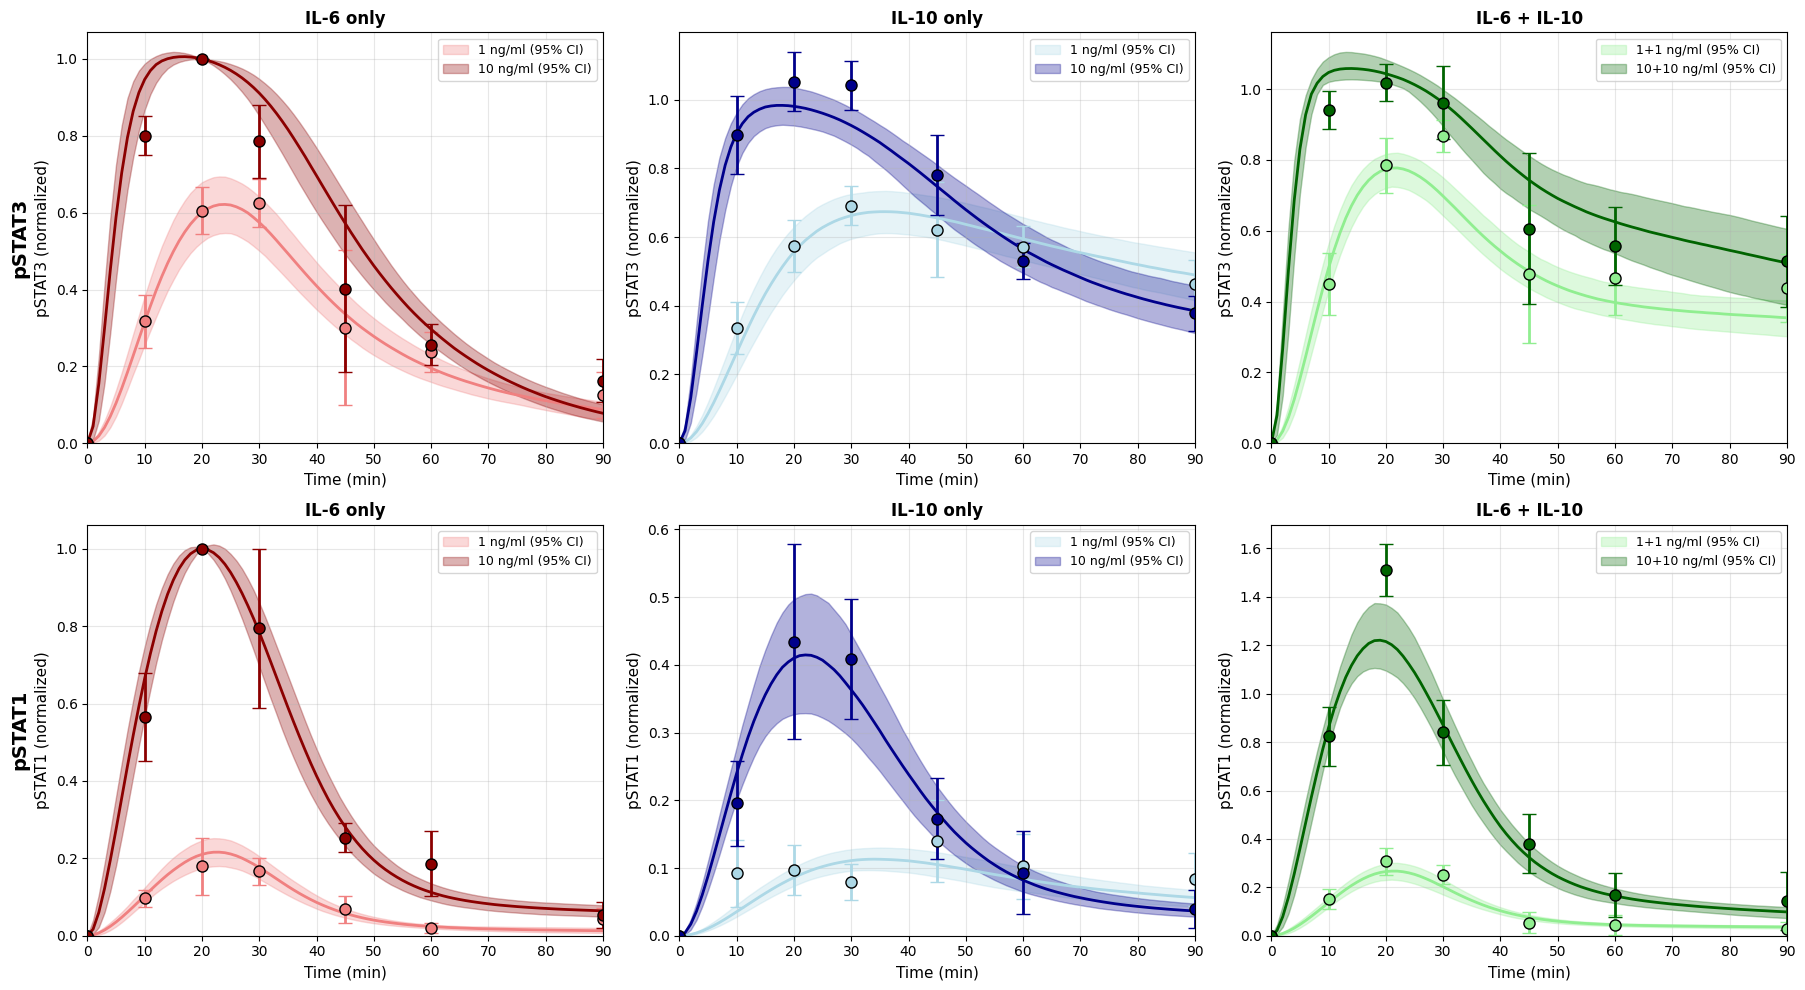


Plot complete!
Note: Shaded regions show 95% confidence intervals from parameter sampling
      Error bars show standard error of the mean (SEM) for experimental data


In [6]:
# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Define plot configurations
# Each entry: (observable_id, observable_name, trajs_df, row_idx)
plot_configs = [
    ('obs_total_pS3', 'pSTAT3', pSTAT3_trajs_norm, 0),
    ('obs_total_pS1', 'pSTAT1', pSTAT1_trajs_norm, 1)
]

# Column configurations: (title, condition_pairs)
# Each condition_pair: (ligand_conc, L1, L2, color, label)
column_configs = [
    ('IL-6 only', [
        (1.0, 1.0, 0.0, 'lightcoral', '1 ng/ml'),
        (10.0, 10.0, 0.0, 'darkred', '10 ng/ml')
    ]),
    ('IL-10 only', [
        (1.0, 0.0, 1.0, 'lightblue', '1 ng/ml'),
        (10.0, 0.0, 10.0, 'darkblue', '10 ng/ml')
    ]),
    ('IL-6 + IL-10', [
        (1.0, 1.0, 1.0, 'lightgreen', '1+1 ng/ml'),
        (10.0, 10.0, 10.0, 'darkgreen', '10+10 ng/ml')
    ])
]

# Plot each subplot
for obs_id, obs_name, trajs_df, row_idx in plot_configs:
    for col_idx, (col_title, cond_pairs) in enumerate(column_configs):
        ax = axes[row_idx, col_idx]
        
        # Plot each condition pair in this column
        for conc, L1, L2, color, label in cond_pairs:
            # Get model trajectory statistics
            median, lower_ci, upper_ci = get_trajectory_stats(trajs_df, L1, L2, param_sets_df)
            
            # Plot 95% confidence interval (shaded region)
            ax.fill_between(time_points, lower_ci, upper_ci, 
                           color=color, alpha=0.3, label=f'{label} (95% CI)')
            
            # Plot median trajectory
            ax.plot(time_points, median, color=color, linewidth=2, linestyle='-')
            
            # Get experimental data
            exp_time, exp_mean, exp_sem = get_experimental_stats(stats_df, L1, L2, obs_id)
            
            # Plot experimental data with error bars (SEM)
            if len(exp_time) > 0:
                ax.errorbar(exp_time, exp_mean, yerr=exp_sem,
                           fmt='o', color=color, markersize=8, 
                           markeredgecolor='black', markeredgewidth=1,
                           capsize=5, capthick=2, elinewidth=2)
        
        # Configure subplot
        ax.set_xlabel('Time (min)', fontsize=11)
        ax.set_ylabel(f'{obs_name} (normalized)', fontsize=11)
        ax.set_title(f'{col_title}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 90)
        ax.set_ylim(bottom=0)

# Add row labels
axes[0, 0].text(-0.15, 0.5, 'pSTAT3', transform=axes[0, 0].transAxes,
               fontsize=14, fontweight='bold', rotation=90, va='center')
axes[1, 0].text(-0.15, 0.5, 'pSTAT1', transform=axes[1, 0].transAxes,
               fontsize=14, fontweight='bold', rotation=90, va='center')

plt.tight_layout()
plt.show()

print("\nPlot complete!")
print("Note: Shaded regions show 95% confidence intervals from parameter sampling")
print("      Error bars show standard error of the mean (SEM) for experimental data")